In [1]:
from q_util import *

In [3]:
df = pd.read_csv("../Data_Generation/Data_files/heisenberg_data.csv")

In [ ]:
# adapted from CS 540 Spring 2023 HW 10
EPISODES = 300000
# EPISODES = 20000
LEARNING_RATE = .9
DISCOUNT_FACTOR = .999
EPSILON = 1
EPSILON_DECAY = .9999

random.seed(1)

# starts with an estimate of zero reward for each state.
# adapted from ChatGPT
agent = QLAgent(qtable=defaultdict(lambda: 0), max_reward=10000, step_penalty=-10)

# TODO make sure this change worked
episode_reward_record = deque(maxlen=500)

for i in range(EPISODES):
    episode_reward = 0
    done = False
    # choose a random starting row
    # adapted from https://stackoverflow.com/questions/15923826/random-row-selection-in-pandas-dataframe
    cur_row = df.sample(1)
    obs = np.array([
        [1, int(cur_row['val1']), int(cur_row['val2'])], 
        [0, 1, int(cur_row['val3'])], 
        [0, 0, 1]
        ])

    index = 1

    while (not done):
        # perform an epsilon greedy action 
        # Q(s, a) = (1-LEARNING_RATE)Q(s, a) + (LEARNING_RATE)(r + DISCOUNT_FACTOR(max a'(Q(s', a'))))
        action = agent.epsilon_greedy_search(epsilon=EPSILON, state=obs)

        oldObs = obs
        obs,reward,done = agent.get_next_step(oldObs, action)

        agent.update_table(obs=obs, reward=reward, discount=DISCOUNT_FACTOR, lr=LEARNING_RATE)

        episode_reward += reward # update episode reward

        index += 1
        # if we take more than 100 steps, end this iteration early (we are probably not making progress)
        if index > 100:
            done=True

    # decay the epsilon
    EPSILON *= EPSILON_DECAY

    # record the reward for this episode
    episode_reward_record.append(episode_reward) 

    if i%5000 ==0 and i>0:
        print("Average reward for the last 5000 iterations: " + str(sum(list(episode_reward_record))/500))
        print("epsilon: " + str(EPSILON) )



In [5]:
# test with the other dataframe. 
test_df = pd.read_csv("../Data_Generation/Data_files/heisenberg_data_test.csv")

In [ ]:
cur_matrix = np.array([[1, int(cur_row['val1']), int(cur_row['val2'])], [0, 1, int(cur_row['val3'])], [0, 0, 1]])

In [ ]:
test_df['num_moves_Q_learning_needs'] = test_df.apply(agent.test_Q_learning, axis=1)

In [ ]:
print("The proportion of starting positions in the test dataset that we can find a route to the origin that's <50 steps: ")
sum(test_df['num_moves_Q_learning_needs']!=100)/test_df.shape[0]

In [ ]:
print("Of these, the proportion of times where we learned a path that was < 20 moves: ")
# encouraging because all of these were generated as sequences of 30 moves
# so we've found significantly faster paths back to the origin for almost all moves that we find a path to the origin 
sum(test_df['num_moves_Q_learning_needs']<20)/sum(test_df['num_moves_Q_learning_needs']!=100)

In [10]:
filtered_df = test_df[test_df['num_moves_Q_learning_needs']!=100]

In [11]:
# because of random generation of points, we have some duplicates
filtered_df = filtered_df[filtered_df.duplicated(keep=False)]

In [12]:
filtered_df = filtered_df.reset_index(drop=True)

In [13]:

filtered_df['first_move_by_Q_learning'] = filtered_df.apply(agent.first_matrix_to_apply, axis=1)

In [14]:
bound = int(filtered_df.shape[0] * 0.6)
plus_one = bound+1
filtered_df = filtered_df.drop_duplicates()
train = filtered_df.iloc[1:bound]
test = filtered_df.iloc[plus_one:filtered_df.shape[0]]

In [15]:
agent.qtable

defaultdict(<function __main__.<lambda>()>,
            {(9, 1, 4): -9.0,
             (10, 1, 4): 0,
             (8, 1, 4): 0,
             (9, 10, 5): 0,
             (9, -8, 3): -9.0,
             (10, -8, 3): 0,
             (8, -8, 3): 0,
             (9, -17, 2): -9.9,
             (10, -17, 2): -9.9,
             (8, -17, 2): -9.0,
             (9, -26, 1): -9.0,
             (7, -17, 2): 0,
             (8, -9, 3): 0,
             (8, -25, 1): 0,
             (10, -26, 1): -9.0,
             (8, -26, 1): 0,
             (9, -35, 0): 0,
             (11, -26, 1): 0,
             (10, -16, 2): -9.9,
             (10, -36, 0): 0,
             (11, -16, 2): -9.0,
             (9, -16, 2): -9.0,
             (10, -6, 3): -9.0,
             (8, -16, 2): 0,
             (9, -7, 3): 0,
             (9, -25, 1): 0,
             (12, -16, 2): -9.0,
             (11, -5, 3): 0,
             (11, -27, 1): 0,
             (13, -16, 2): 0,
             (12, -4, 3): 0,
             (12, -28,

In [31]:
train_values = train.copy(deep=True)
test_values = test.copy(deep=True)

In [29]:
set(train_values['first_move_by_Q_learning'])

{0, 1, 2, 3}

In [32]:
train_values['Q_table_val'] = train_values.apply(agent.get_Q_value, axis=1)
test_values['Q_table_val'] = test_values.apply(agent.get_Q_value, axis=1)

In [34]:
train_values.to_csv("../Data_Generation/Data_files/Q_moves_scores.csv", index=False)
test_values.to_csv("../Data_Generation/Data_files/Q_moves_scores_test.csv", index=False)

In [222]:
row = dict()
row['val1'], row['val2'], row['val3'] = matrix_to_tuple(A@A@A@C@B@D@B@D@B)
agent.first_matrix_to_apply(row)

In [225]:
outputs = [0, 0, 0, 0]

cur_matrix = A@A@A@A@A@D@B
print(cur_matrix)

outputs[0] = agent.qtable[matrix_to_tuple(cur_matrix@ A)]
outputs[1] = agent.qtable[matrix_to_tuple(cur_matrix@ B)]
outputs[2] = agent.qtable[matrix_to_tuple(cur_matrix@ C)]
outputs[3] = agent.qtable[matrix_to_tuple(cur_matrix@ D)]
outputs

[[ 1  4 -5]
 [ 0  1 -1]
 [ 0  0  1]]


[9880.299600299879, 9880.299600299879, 9880.299600299879, 9840.55888139888]

In [226]:
results = []

results.append((agent.matrix_to_num_steps(A@A@A@A), 3))
results.append((agent.matrix_to_num_steps(A@A@A@A@A), 4))
results.append((agent.matrix_to_num_steps(B@B@B@B), 3))
results.append((agent.matrix_to_num_steps(B@B@B@B@B), 4))
results.append((agent.matrix_to_num_steps(C@C@C@C), 3))
results.append((agent.matrix_to_num_steps(C@C@C@C@C), 4))
results.append((agent.matrix_to_num_steps(D@D@D@D), 3))
results.append((agent.matrix_to_num_steps(D@D@D@D@D), 4))
results.append((agent.matrix_to_num_steps(A@C), 1))
results.append((agent.matrix_to_num_steps(A@C@C), 2))
results.append((agent.matrix_to_num_steps(B@C), 1))
results.append((agent.matrix_to_num_steps(B@C@C), 2))

results

[(3, 3),
 (4, 4),
 (3, 3),
 (4, 4),
 (3, 3),
 (4, 4),
 (3, 3),
 (4, 4),
 (1, 1),
 (2, 2),
 (1, 1),
 (2, 2)]

In [231]:
problem_cases = test_df[test_df['num_moves_Q_learning_needs']==100]

In [232]:
first_row = problem_cases.iloc[1]

In [233]:
test_mat = np.array([[1, first_row['val1'], first_row['val2']], [0, 1, first_row['val3']], [0, 0, 1]])

In [237]:
def add_if_loop_to_df(row): 
    test_mat = np.array([[1, row['val1'], row['val2']], [0, 1, row['val3']], [0, 0, 1]])
    seen = set()
    return do_we_loop(seen, test_mat)
problem_cases['do_we_loop'] = problem_cases.apply(add_if_loop_to_df, axis=1)

C:\Users\16089\AppData\Local\Temp\ipykernel_24624\2113995181.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  problem_cases['do_we_loop'] = problem_cases.apply(add_if_loop_to_df, axis=1)


In [238]:
sum(problem_cases['do_we_loop'])/problem_cases.shape[0]
# we almost always loop within 20 moves

0.3387096774193548

In [239]:
def min_a_b_sqrt_c(row):
    return min(abs(row['val1']), 
    abs(row['val3']), 
    math.sqrt(abs(row['val2'])))

def max_a_b_sqrt_c(row):
    return max(abs(row['val1']), 
    abs(row['val3']), 
    math.sqrt(abs(row['val2'])))

test_df['min_a_b_sqrt_c'] = test_df.apply(min_a_b_sqrt_c, axis=1)
test_df['max_a_b_sqrt_c'] = test_df.apply(max_a_b_sqrt_c, axis=1)

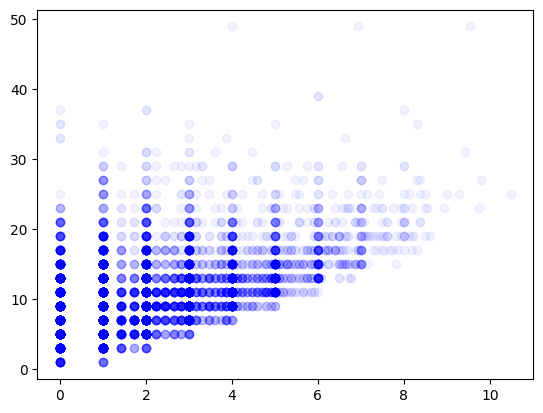

In [240]:
non_problems = test_df[test_df['num_moves_Q_learning_needs']!=100]
plt.scatter(non_problems['min_a_b_sqrt_c'], non_problems['num_moves_Q_learning_needs'], c="blue", alpha=0.05)

In [241]:
# gotta count the number of commutators
# given a sequence, want to count the number of commutators
# a sequence like AACCBBDD has 1 commutator. ACBDACBD has 2 commutators. I think I've got the right def for commutator

In [242]:
non_problems.to_csv('../Visualizations/viz_a_b_sqrt_c.csv', index=False)

In [246]:
# Q_table_to_df_and_save(Q_table)
# turns a Q_table into a dataframe and saves it

In [247]:
# Q_table_new = pd.read_csv("../Data_Generation/Data_files/Q_table_df.csv")